In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = True
FTYPE = np.float32
ITYPE = np.int32

# strategy = None
strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

Mounted at /content/drive


In [6]:
print(os.getcwd())

/content/drive/MyDrive/Github/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v3 import Autoencoder
from tools.GRU_SingleStep_v6 import RNN_GRU

In [8]:
# behaviour = 'initialiseAndTrainFromScratch'
behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[]


In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU')]
2.9.2


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_rnn'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')

    # autoencoder directory
    ae_idx = '009'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_008'

    # reading AE directory
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']

print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

fl = np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True)
all_data = fl['all_data']
boundary_idx_arr = fl['boundary_idx_arr']
normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
initial_t0 = fl['initial_t0']
init_state_mat = fl['init_state_mat']

lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /content/drive/MyDrive/Github/MLROM/KS/saved_rnn/rnn_008
dir_name_ae: /content/drive/MyDrive/Github/MLROM/KS/saved_ae/ae_009
data_dir_idx: 001
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.07866301843612732, lyapunov time : 12.712453842163086s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

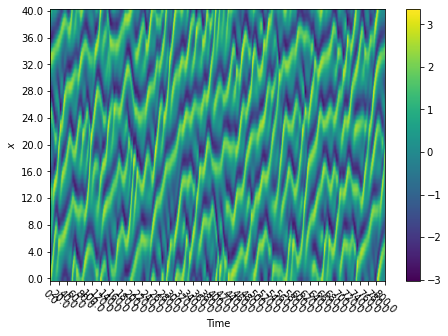

In [15]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid)

In [16]:
# delaing with normalizing the data before feeding into autoencoder
if normalizeforae_flag == True:
    for i in range(numpoints_xgrid):
        all_data[:, i] -= normalization_constant_arr_aedata[0, i]
        all_data[:, i] /= normalization_constant_arr_aedata[1, i]

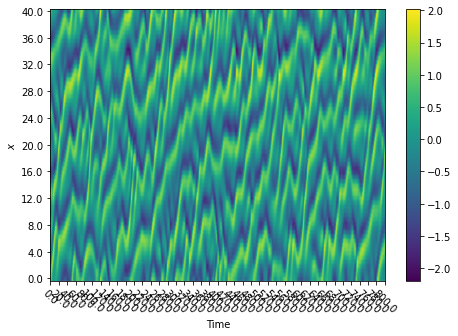

In [17]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid)

# Autoencoder

In [18]:
# load_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_class_dict.txt'
# wt_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_ae_weights.h5'

# if colab_flag == False:
#     dir_name_ae_og = dir_name_ae
#     dir_name_ae_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_'+ae_idx
#     dir_name_ae = dir_name_ae_temp

load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

# if colab_flag == False:
#     dir_name_ae = dir_name_ae_og

In [19]:
ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
ae_net.load_weights_from_file(wt_file)

In [20]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)
num_latent_states = latent_states_all.shape[1]

251/251 [==============================] - 1s 2ms/step


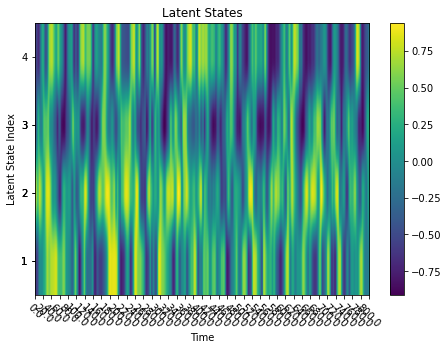

In [21]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=20,
    num_yticks=11,
    save_figs=False)

In [22]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# GRU

In [23]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = 3
    dt_rnn = 0.1
    T_sample_input = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving simulation data
    sim_data = {
        'params_mat':params_mat,
        'init_state_mat':init_state_mat,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr,
        'dir_name_ae':dir_name_ae,
        'normalize_dataset':normalize_dataset,
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [24]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [25]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_dict = {
        'eta_begin':0.0001,
        'eta_high':0.001,
        'eta_low':0.00001
    }
    epochs = 2000
    patience = 25  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-4  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64
    fRMS = 0.05

    # saving training params
    training_specific_params = {
        'learning_rate_dict':learning_rate_dict,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    learning_rate_dict = tparams_dict['learning_rate_dict']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [26]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [27]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train += int( (1-test_split-val_split)*num_samples )
    num_val += int(val_split*num_samples)
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [num_train]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [num_train]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [num_val]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [num_train]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [cum_samples-num_train-num_val]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [cum_samples-num_train-num_val]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

val_data_rnn_input = np.empty(shape=val_input_shape)
val_data_rnn_output = np.empty(shape=val_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    num_samples = idx.shape[0]
    num_train = int( (1-test_split-val_split)*num_samples )
    num_val = int(val_split*num_samples)

    training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val+1
    testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# further shuffling
idx = np.arange(0, training_data_rnn_input.shape[0])
np.random.shuffle(idx)
training_data_rnn_input = training_data_rnn_input[idx]
training_data_rnn_output = training_data_rnn_output[idx]

idx = np.arange(0, val_data_rnn_input.shape[0])
np.random.shuffle(idx)
val_data_rnn_input = val_data_rnn_input[idx]
val_data_rnn_output = val_data_rnn_output[idx]

idx = np.arange(0, testing_data_rnn_input.shape[0])
np.random.shuffle(idx)
testing_data_rnn_input = testing_data_rnn_input[idx]
testing_data_rnn_output = testing_data_rnn_output[idx]

In [28]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    rnn_layers_units = [2**8]*1
    timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
    stddev = fRMS*timeMeanofSpaceRMS
    print('timeMeanofSpaceRMS :', timeMeanofSpaceRMS)
    print('stddev :', stddev)
    if return_params_arr != False:
        data_dim = num_latent_states + 3
    else:
        data_dim = num_latent_states

    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                data_dim=data_dim,
            #     in_steps=int(T_sample_input // dt_rnn),
            #     out_steps=int(T_sample_output // dt_rnn),
                dt_rnn=dt_rnn,
                lambda_reg=lambda_reg,
                reg_name='L2',
                rnn_layers_units=rnn_layers_units,
                dense_layer_act_func='linear',
                load_file=None,
                # T_input=T_sample_input,
                # T_output=T_sample_output,
                stddev=stddev
            )
    else:
        rnn_net = RNN_GRU(
            data_dim=data_dim,
        #     in_steps=int(T_sample_input // dt_rnn),
        #     out_steps=int(T_sample_output // dt_rnn),
            dt_rnn=dt_rnn,
            lambda_reg=lambda_reg,
            reg_name='L2',
            rnn_layers_units=rnn_layers_units,
            dense_layer_act_func='linear',
            load_file=None,
            # T_input=T_sample_input,
            # T_output=T_sample_output,
            stddev=stddev
        )
    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                load_file=load_file,
                # T_input=T_sample_input,
                # T_output=T_sample_output
            )
    else:
        rnn_net = RNN_GRU(
            load_file=load_file,
            # T_input=T_sample_input,
            # T_output=T_sample_output
        )
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_gru_weights.h5'
        # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)
    
    # this forces the model to initialize its kernel weights/biases
    # temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    # this loads just the kernel wieghts and biases of the model
#     rnn_net.load_weights_from_file(wt_file)

    # rnn_net = tf.keras.models.load_model(wt_file)

1/1 [==============================] - 2s 2s/step


In [29]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs)*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs)*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
    earlystopping_wait = 0
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
        dir_name_ae=dir_name_rnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=[0],
        return_earlystopping_wait=True)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [30]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_dict['eta_begin']),
    loss=losses.MeanSquaredError(),
    run_eagerly=False
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            rnn_net.load_weights(wt_file)
    else:
        rnn_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    baseline = None
    if behaviour == 'loadCheckpointAndContinueTraining':
        baseline = np.min(val_loss_hist)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta,
        baseline=baseline
    )
    # the below two lines are useless because wait is set to 0 in on_train_begin
    # early_stopping_cb.wait = earlystopping_wait
    # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_rnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        initial_value_threshold=baseline,
        period=1  # saves every `period` epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)
    
    # sigmoid annealing lr schedule
    lrschedule_cb = sigmoidWarmupAndDecayLRSchedule(
        eta_begin=learning_rate_dict['eta_begin'],
        eta_high=learning_rate_dict['eta_high'],
        eta_low=learning_rate_dict['eta_low'],
        warmup=10,
        expected_epochs=25,
        g_star=0.999,
        f_star=0.001
    )

    # training the network
    savelosses_cb.update_offset(epochs - num_epochs_left)
    
    history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
        epochs=num_epochs_left,
        batch_size=batch_size,
        # validation_split=val_split/(train_split+val_split),
        validation_data=(val_data_rnn_input, val_data_rnn_output),
        callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb, lrschedule_cb],
        verbose=1
    )

    val_loss_hist.extend(history.history['val_loss'])
    train_loss_hist.extend(history.history['loss'])

Epoch 1/1705
96/96 [==============================] - ETA: 0s - loss: 0.0016 - tot_time: 0h 4m 17.4s

Epoch 1: val_loss improved from 0.00162 to 0.00161, saving model to /content/drive/MyDrive/Github/MLROM/KS/saved_rnn/rnn_008/checkpoints/checkpoint
 - saving loss histories at /content/drive/MyDrive/Github/MLROM/KS/saved_rnn/rnn_008/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 257s 2s/step - loss: 0.0016 - val_loss: 0.0016
Epoch 2/1705
96/96 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 6m 22.8s

Epoch 2: val_loss improved from 0.00161 to 0.00160, saving model to /content/drive/MyDrive/Github/MLROM/KS/saved_rnn/rnn_008/checkpoints/checkpoint
 - saving loss histories at /content/drive/MyDrive/Github/MLROM/KS/saved_rnn/rnn_008/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 126s 1s/step - loss: 0.0015 - val_loss: 0.0016
Epoch 3/1705
96/96 [==============================] - ETA: 0s - loss: 0.0015 - tot

In [31]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_loss = rnn_net.evaluate(
        testing_data_rnn_input, testing_data_rnn_output,
    )

    save_path = dir_name_rnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'lr_change':lr_change,
            'test_loss':test_loss
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

24/24 [==============================] - 6s 265ms/step - loss: 0.0013


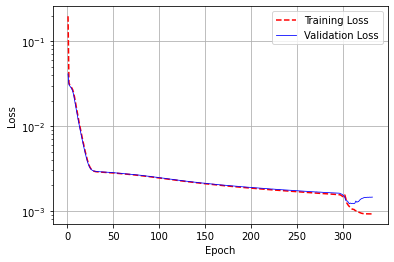

In [32]:
# plotting losses
dir_name_plot = dir_name_rnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=None
)

plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


data_idx : 544
1/1 [==============================] - 10s 10s/step


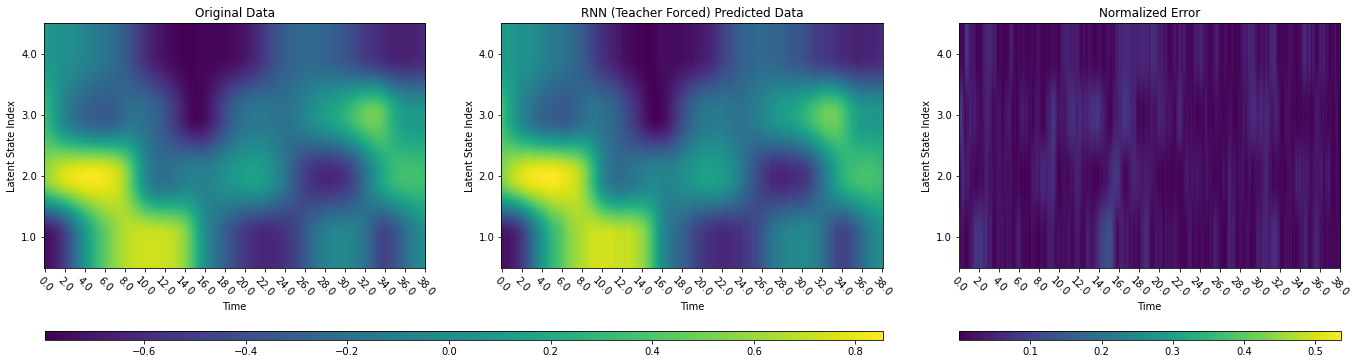

In [33]:
# data_type = 'training'
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])

plot_reconstructed_data_KS(
    [data_out.shape[0]],
    dir_name_ae,
    data_out,
    prediction[0], delta_t, 1+np.arange(0, data_out.shape[1]),
    save_figs=False,
    normalization_constant_arr=normalization_arr,
    xticks_snapto=2,
    num_yticks=data_out.shape[1],
    ylabel=r'Latent State Index',
    ax1_title=r'Original Data',
    ax2_title=r'RNN (Teacher Forced) Predicted Data')

In [34]:
prediction.shape, data_out.shape

((1, 381, 4), (381, 4))